### Neural Networks as Function Approximators for Hyperspectral Imaging

In Neural Radiance Fields (NeRFs), Multi-Layer-Perceptrons (MLPs) are used to represent three-dimensional scenes.

<img src="https://uploads-ssl.webflow.com/51e0d73d83d06baa7a00000f/5e700ef6067b43821ed52768_pipeline_website-01.png" width="640px" />

To render an image, rays are cast into the scene for each image pixel, and query points along the ray are fed into an MLP to retrieve the density and color at this position.

Thus, for NeRFs, the network takes a 5-dimensional input (position and angles), and produces a density and color value:

<img src="https://uploads-ssl.webflow.com/51e0d73d83d06baa7a00000f/5e700a025ff238947d682a1f_pipeline_website-03.svg" width="400px" />

NeRFs demonstrate that MLPs are powerful tools to approximate any high-dimensional function. In this exercise, we will apply this idea to represent images in the same fashion, instead of 3D scenes.

We want to represent 2D images with an MLP $F$. Our image is defined as an intensity $I(x,y)$ over two coordinates, $x$ and $y$.

Thus, our most basic network will take a two-dimensional input, and produce a one-dimensional output:

$$ (x, y) → F_I → I $$

As the network sees only one pair of coordinates at a time, we will have to query our network many times, for each and every pixel, to generate a full image.

### Prerequisites

If you have questions about this exercise or need help, you can contact Sophie at sophie.beckmann@hhi.fraunhofer.de

First, we need to install the necessary packages and load the data.


**Make sure to request GPUs from Colab!**

-> Small arrow in the top-right corner -> "View Resources" -> "Change runtime type" (in the bottom)

**Make a copy to allow saving!**

In [ ]:
!pip install torch torchvision imageio torchinfo matplotlib pandas

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchinfo
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import pandas as pd

# make the results reproducible
torch.manual_seed(42)

#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:2')
print(f"Using {device} as PyTorch device")

Using cuda:2 as PyTorch device


To import the data, please access the link below, right click on the .zip file, then click "Add shortcut to Drive" and select your Drive folder:

https://drive.google.com/drive/folders/1wEeFvnKMXxpw8LWlFbCw8cmgydeFfeuX?usp=sharing

In [6]:
# load data
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

img_file = "/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_07/content/st_michel.JPG"
org_img = iio.imread(img_file, mode="L")

def imshow(tensor_img, colorbar=False):
    """Display a tensor as an image, nearest interpolation."""
    show = plt.imshow(tensor_img.squeeze(0).cpu(), interpolation="nearest")
    if colorbar:
        plt.colorbar(show)
    plt.show()


def gray_imshow(tensor_img, colorbar=False):
    """Display a tensor as a grayscale image (no color map), nearest interpolation."""
    show = plt.imshow(tensor_img.squeeze(0).cpu(), cmap="gray", interpolation="nearest")
    if colorbar:
        plt.colorbar(show)
    plt.show()

def downsampled_img_tensor(pil_img, img_scale=0.5):

    # image as tensor
    # [batch x channels x height x width]
    org_img_tensor = torchvision.transforms.ToTensor()(pil_img).unsqueeze(0)

    img_downsampled = torch.nn.functional.interpolate(
        org_img_tensor, scale_factor=img_scale, mode="bilinear", align_corners=False
    )
    img_downsampled = img_downsampled.squeeze(0).squeeze(0).to(device)

    return img_downsampled

img_downsampled = downsampled_img_tensor(org_img, img_scale=1/2)


We've loaded this image, which we want to represent with a network:

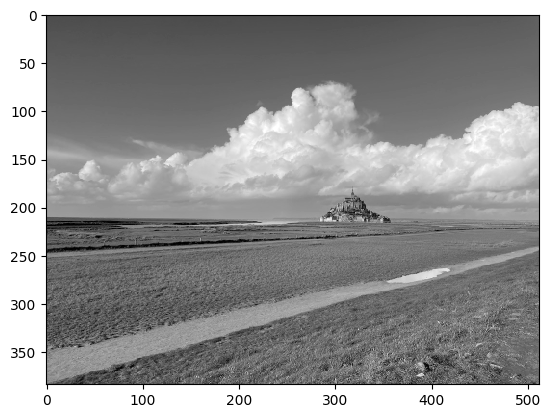

In [7]:
gray_imshow(img_downsampled)

### Representing a gray image with a simple MLP

Now, let's set up a simple network, that maps from input coordinates to output intensity.

In [8]:
class mlp(torch.nn.Module):
    """A simple MLP that takes 2D coordinates as input and outputs an estimation of the grayscale value at this pixel coordinate.
       Thus, the input is of shape [batch x 2] and the output is of shape [batch x 1].
    """

    def __init__(self):
        super(mlp, self).__init__()

        self.fc1 = torch.nn.Linear(2, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

Now we need a tensor that stores the coordinates for each pixel (to query the network with). We choose the coordinate range of [-1..1] for both x and y.

In [9]:
def create_coord_grid_2d(height, width):
    # Initialize grid with shape (2, height, width)
    # np.mgrid generates a grid that contains the coordinates of each pixel.
    # The coordinates are separated into two 2D arrays: one for the y (row) coordinates
    # and another for the x (column) coordinates.
    yx_grid = np.mgrid[:height, :width].astype(np.float32)

    # Move grid coordinates to pixel center
    # This is done by adding 0.5 to all coordinates, which effectively shifts
    # the grid so that the coordinates refer to the pixel centers, not their top-left corners.
    yx_grid += 0.5

    # Normalize grid coordinates to [0, 1] range
    yx_grid[0] /= height
    yx_grid[1] /= width

    # Rescale grid coordinates to [-1, 1] range
    yx_grid = yx_grid * 2 - 1

    # Transpose grid to [xy, h, w]
    # The yx_grid is currently in [yx, h, w] format,
    # where yx represents a stack of y (row) and x (column) coordinates.
    # Here we reverse the coordinate stack to [x, y], or [xy, h, w].
    xy_grid = yx_grid[::-1]

    # Reshape grid to [h, w, xy] format and convert to PyTorch tensor
    xy_grid_t = torch.tensor(np.ascontiguousarray(xy_grid)).permute(1, 2, 0)

    return xy_grid_t

# [h, w, xy]
coord_grid = create_coord_grid_2d(
    height=img_downsampled.shape[-2], width=img_downsampled.shape[-1]
).to(device)

Let's check the results, first let's look at the x coordinates for the whole image:

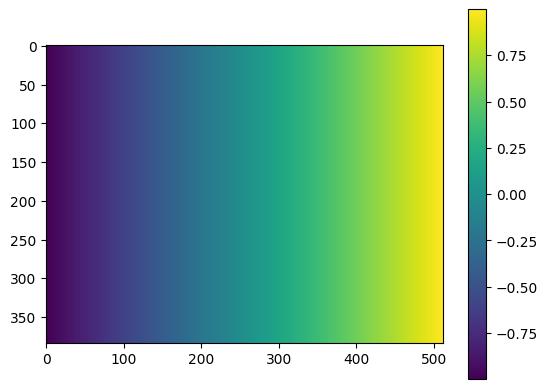

In [10]:
# x coordinates are the first value of the last dimension of the grid
imshow(coord_grid[..., 0], colorbar=True)

And the y coordinates:

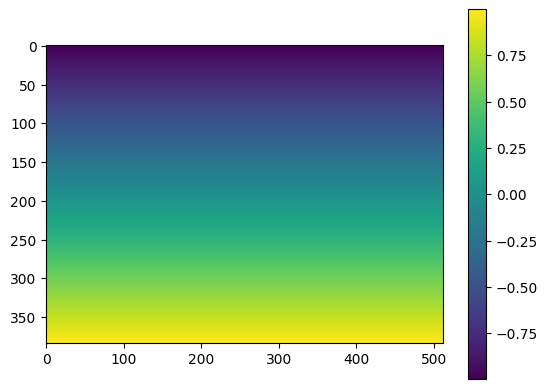

In [11]:
# y coordinates
imshow(coord_grid[..., 1], colorbar=True)

For the training loop, we feed the coordinate grid into the network. Remember: our network produces one intensity value for one pixel. Thus the height and width dimensions of our coordinate grid are effectively the batch dimensions of our network during training - the network never sees an image, it only sees individual coordinates.

In [12]:
def train(model, input, expected_output, num_epochs, loss_print_interval=100, show_interval=10000):

    model_info = torchinfo.summary(model)
    # first two batch dimensions are always height and width
    print(f"Image size: {input.shape[1]} x {input.shape[0]}")
    print(
        f"Image pixels per trainable parameter: {np.prod(input.shape[:2]) / model_info.trainable_params:.2f}"
    )
    print(model_info)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        prediction = model(input).squeeze(-1)

        loss = loss_fn(expected_output, prediction)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % loss_print_interval == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        if epoch > 0:
          if epoch % show_interval == 0 or epoch == num_epochs - 1:
              gray_imshow(prediction.detach(), colorbar=True)

Let's instantiate the model and train the network for 1000 epochs. When training is finished, it will show the predicted image.

Image size: 512 x 384
Image pixels per trainable parameter: 11.55
Layer (type:depth-idx)                   Param #
mlp                                      --
├─Linear: 1-1                            384
├─Linear: 1-2                            16,512
├─Linear: 1-3                            129
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
Epoch [1/1000], Loss: 0.0268
Epoch [101/1000], Loss: 0.0062
Epoch [201/1000], Loss: 0.0054
Epoch [301/1000], Loss: 0.0050
Epoch [401/1000], Loss: 0.0051
Epoch [501/1000], Loss: 0.0049
Epoch [601/1000], Loss: 0.0042
Epoch [701/1000], Loss: 0.0041
Epoch [801/1000], Loss: 0.0039
Epoch [901/1000], Loss: 0.0040
Epoch [1000/1000], Loss: 0.0038


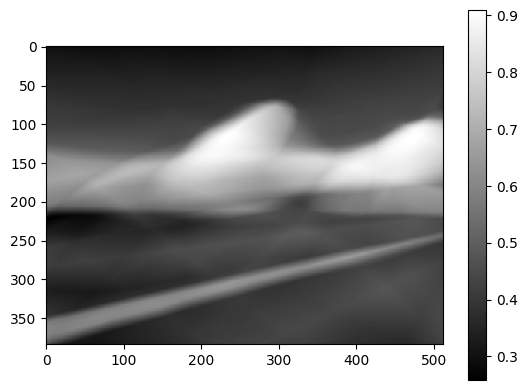

In [13]:
model = mlp().to(device)

train(model=model, input=coord_grid, expected_output=img_downsampled, num_epochs=1000, loss_print_interval=100, show_interval=10000)

It looks like an artistic rendering of the input image, but we are missing all the details.

### Task 1 - Experiment with different network sizes

Rewrite the static MLP module definition, to make the number of layers and the layer width configurable. Then do a few experiments with different network configurations.

What is the best image and lowest MSE loss you can produce, while using no more than one network parameter per 4 pixels?

(Check "Image pixels per trainable parameter" >= 4 in the training output message).

You should carefully watch the loss during training: if it gets stuck at the beginning (e.g. by only producing black images), you may have to decrease the learning rate.

Here's the stub for your configurable network:

Image size: 512 x 384
Image pixels per trainable parameter: 59.63
Layer (type:depth-idx)                   Param #
mlp_configurable                         --
├─Linear: 1-1                            96
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       1,056
│    └─Linear: 2-2                       1,056
│    └─Linear: 2-3                       1,056
├─Linear: 1-3                            33
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
Epoch [1/1000], Loss: 0.0267
Epoch [101/1000], Loss: 0.0061
Epoch [201/1000], Loss: 0.0054
Epoch [301/1000], Loss: 0.0040
Epoch [401/1000], Loss: 0.0037
Epoch [501/1000], Loss: 0.0036
Epoch [601/1000], Loss: 0.0035
Epoch [701/1000], Loss: 0.0035
Epoch [801/1000], Loss: 0.0034
Epoch [901/1000], Loss: 0.0034
Epoch [1000/1000], Loss: 0.0033


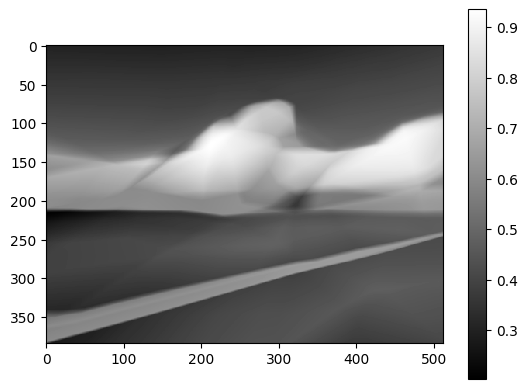

In [14]:
class mlp_configurable(nn.Module):
    def __init__(self, input_dim=2, num_hidden_layers=3, hidden_layer_width=32):
        super(mlp_configurable, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(input_dim, hidden_layer_width)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_layer_width, hidden_layer_width))

        # Output layer
        self.output_layer = nn.Linear(hidden_layer_width, 1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input layer
        x = self.relu(self.input_layer(x))
        
        for f in self.hidden_layers:
            x = f(x)
            x = self.relu(x)

        # Output layer
        x = self.sigmoid(self.output_layer(x))

        return x

model_configurable = mlp_configurable().to(device)

train(model=model_configurable, input=coord_grid, expected_output=img_downsampled, num_epochs=1000, loss_print_interval=100, show_interval=10000)

Image size: 512 x 384
Image pixels per trainable parameter: 2.37
Layer (type:depth-idx)                   Param #
mlp_configurable                         --
├─Linear: 1-1                            384
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Linear: 2-4                       16,512
│    └─Linear: 2-5                       16,512
├─Linear: 1-3                            129
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 83,073
Trainable params: 83,073
Non-trainable params: 0
Epoch [1/1000], Loss: 0.0265
Epoch [101/1000], Loss: 0.0048
Epoch [201/1000], Loss: 0.0038
Epoch [301/1000], Loss: 0.0034
Epoch [401/1000], Loss: 0.0032
Epoch [501/1000], Loss: 0.0032
Epoch [601/1000], Loss: 0.0032
Epoch [701/1000], Loss: 0.0028
Epoch [801/1000], Loss: 0.0028
Epoch [901/1000], Loss: 0.0028
Ep

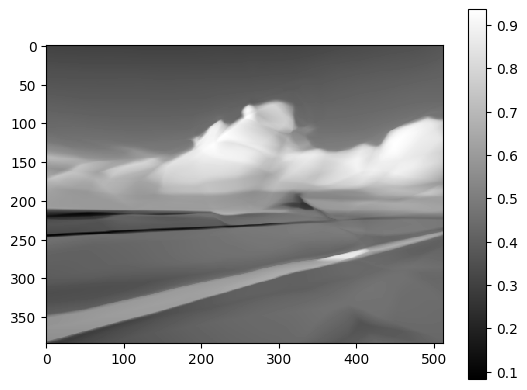

In [15]:
model_configurable = mlp_configurable(num_hidden_layers=5, hidden_layer_width=128).to(device)

train(model=model_configurable, input=coord_grid, expected_output=img_downsampled, num_epochs=1000, loss_print_interval=100, show_interval=10000)

Image size: 512 x 384
Image pixels per trainable parameter: 0.07
Layer (type:depth-idx)                   Param #
mlp_configurable                         --
├─Linear: 1-1                            1,536
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       262,656
│    └─Linear: 2-2                       262,656
│    └─Linear: 2-3                       262,656
│    └─Linear: 2-4                       262,656
│    └─Linear: 2-5                       262,656
│    └─Linear: 2-6                       262,656
│    └─Linear: 2-7                       262,656
│    └─Linear: 2-8                       262,656
│    └─Linear: 2-9                       262,656
│    └─Linear: 2-10                      262,656
├─Linear: 1-3                            513
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 2,628,609
Trainable params: 2,628,609
Non-trainable params: 0
Epoch [1/1000], Loss: 0.0265
Epoch [101/1000], Loss:

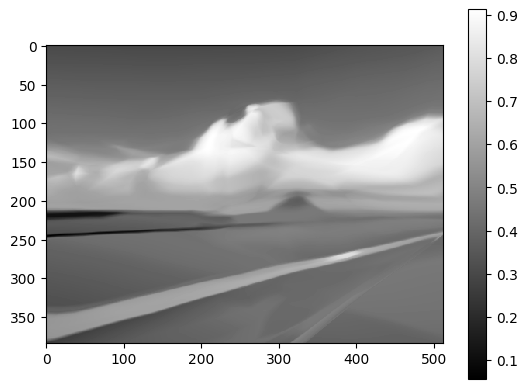

In [16]:
model_configurable = mlp_configurable(num_hidden_layers=10, hidden_layer_width=512).to(device)

train(model=model_configurable, input=coord_grid, expected_output=img_downsampled, num_epochs=1000, loss_print_interval=100, show_interval=10000)

As you will probably notice, it's really difficult for such a network to learn the high-frequency changes of the image signal. But there's a trick to help the network to learn better, by feeding it a different encoding of the input coordinates.

### Positional Encoding (Frequency Coding)

In positional encoding, an one-dimensional input coordinate is mapped into a higher dimension. In NeRFs, it is defined as

$ p(x) = (sin(2^0 \pi x), cos(2^0 \pi x), ..., sin(2^{L-1} \pi x), cos(2^{L-1} \pi x)) $

This function is applied separately to the input dimensions, in our case, to $x$ and $y$. $L$ is the number of frequencies that are used.

### Task 2 - Positional Encoding Implementation

Our network now changes from

$$ (x, y) → F_I → I $$

to

$$ (p(x), p(y)) → F_E → I $$

Complete the implementation of the positional encoding below. Then plot the encoded coordinate images (akin to the plots of the `coord_grid` above). To make sure your implementation is correct, check that it looks similar to the visualizations of the "Encoded Values" in https://docs.nerf.studio/en/latest/nerfology/model_components/visualize_encoders.html - showing different frequencies in different dimensions.

In [18]:
def positional_encoding(x, y, num_frequencies=4):
    """
    Encodes x and y coordinates using sine and cosine functions with different frequencies.

    This is the positional encoding scheme used in Neural Radiance Fields.

    Args:
        x (torch.Tensor): The x coordinates.
        y (torch.Tensor): The y coordinates.
        num_frequencies (int): The number of different frequencies to use.

    Returns:
        torch.Tensor: The encoded coordinates.
    """
    # Initialize encoding
    encoding = []

    # Encode x & y using sine and cosine functions with different frequencies
    for i in range(num_frequencies):
        frequency = 2**i * np.pi

        encoding.append(torch.sin(frequency * x))
        encoding.append(torch.cos(frequency * x))
        encoding.append(torch.sin(frequency * y))
        encoding.append(torch.cos(frequency * y))

    # Concatenate the encodings
    encoding = torch.stack(encoding, dim=-1)

    return encoding

# Assuming coord_grid is your coordinate grid tensor of shape [height, width, xy=2]
x_coords = coord_grid[..., 0]
y_coords = coord_grid[..., 1]

# Encode the coordinates
# [h, w, coord_encoding]
NUM_FREQ = 8
encoded_coords = positional_encoding(x_coords, y_coords, num_frequencies=NUM_FREQ)

# check: [height, width, num_freq * 4 (4=sin x, cos x, sin y, cos y)]
assert(encoded_coords.shape == (img_downsampled.shape[-2], img_downsampled.shape[-1], NUM_FREQ * 4))
coord_encoding_len = encoded_coords.shape[-1]

With the implementation working, let's put it to use as the input for the MLP. Use the best MLP configuration that you were able to find in Task 1.

Image size: 512 x 384
Image pixels per trainable parameter: 2.26
Layer (type:depth-idx)                   Param #
mlp_configurable                         --
├─Linear: 1-1                            4,224
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Linear: 2-4                       16,512
│    └─Linear: 2-5                       16,512
├─Linear: 1-3                            129
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 86,913
Trainable params: 86,913
Non-trainable params: 0
Epoch [1/1000], Loss: 0.0264
Epoch [101/1000], Loss: 0.0025
Epoch [201/1000], Loss: 0.0019
Epoch [301/1000], Loss: 0.0020
Epoch [401/1000], Loss: 0.0016
Epoch [501/1000], Loss: 0.0015
Epoch [601/1000], Loss: 0.0015
Epoch [701/1000], Loss: 0.0013
Epoch [801/1000], Loss: 0.0012
Epoch [901/1000], Loss: 0.0013


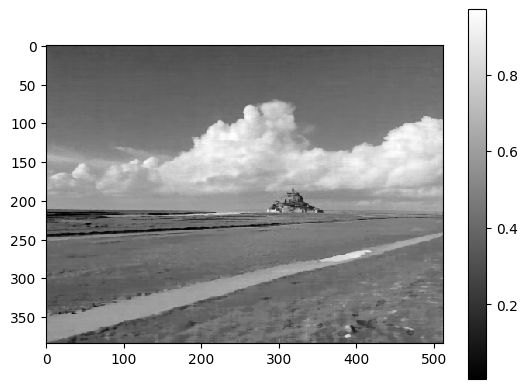

In [19]:
# Note: our input dimension is no longer 2 (xy), it is now the length of the positional encoding

enc_model = mlp_configurable(input_dim=coord_encoding_len, num_hidden_layers=5, hidden_layer_width=128).to(
    device
)

train(model=enc_model, input=encoded_coords, expected_output=img_downsampled, num_epochs=1000, loss_print_interval=100, show_interval=10000)


In the trained output, you should now see a much closer representation of our input image - although the size of our network has not changed (except for a few more parameters for the connection of the input to the first hidden layer)!

### Task 3 - Image description

Describe the differences you see in the output, of the network using positional encoding, compared to the simple coordinate encoding. Can you explain why the network behaves differently? Are there any noticable artefacts in the pos-encoded output image?

**Answer:**

...

### Representing Color Images

As the next step, we want to add color to the image. One option would be to have the network produce three output intensities instead of one (one each for the red, green, and blue channels). But, as we want to add more color channels later, we will go another route: making the color an additional input query.

Thus, our updated network will look like this:

$$ (p(x), p(y), c) → F_C → I $$

To produce a full color image, we will have to query the network three times at each pixel, once for each channel.

To represent our color $c$, we choose the values -1 for red, 0 for green and 1 for blue.

In [20]:
rgb_img = iio.imread(img_file)
rgb_img_downsampled = downsampled_img_tensor(rgb_img, img_scale=0.5)

# let's repeat the encoded coordinates 3 times into a new dimension,
# which will become the color channel dimension
# [h, w, 3, coord_encoding]
encoded_coords_repeated = encoded_coords.unsqueeze(2).repeat((1, 1, 3, 1))

def rgb_grid(height, width):
    """This is the color encoding at each pixel."""
    rgb_grid = torch.zeros(height, width, 3, dtype=torch.float32)
    # red
    rgb_grid[..., 0] = -1
    # green
    rgb_grid[..., 1] = 0
    # blue
    rgb_grid[..., 2] = 1
    return rgb_grid

# [h, w, 3]
rgb_vals = rgb_grid(
    height=rgb_img_downsampled.shape[-2], width=rgb_img_downsampled.shape[-1]
).to(device)

# color is now an additional input dimension to the network
# the value will always be -1, 0 or 1
rgb_input_dim = coord_encoding_len + 1

# we now also have an additional (third) batch dimension, the color,
# as we need to query the network three times at each pixel
# [h, w, 3, rgb_input_dim]
rgb_coord_queries = torch.cat([encoded_coords_repeated, rgb_vals.unsqueeze(-1)], dim=-1)


Training this network, you should finally get to see green grass and a blue sky.

Image size: 512 x 384
Image pixels per trainable parameter: 2.26
Layer (type:depth-idx)                   Param #
mlp_configurable                         --
├─Linear: 1-1                            4,352
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Linear: 2-4                       16,512
│    └─Linear: 2-5                       16,512
├─Linear: 1-3                            129
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 87,041
Trainable params: 87,041
Non-trainable params: 0
Epoch [1/1000], Loss: 0.0420
Epoch [101/1000], Loss: 0.0034
Epoch [201/1000], Loss: 0.0025
Epoch [301/1000], Loss: 0.0019
Epoch [401/1000], Loss: 0.0017
Epoch [501/1000], Loss: 0.0017
Epoch [601/1000], Loss: 0.0016
Epoch [701/1000], Loss: 0.0016
Epoch [801/1000], Loss: 0.0015
Epoch [901/1000], Loss: 0.0014


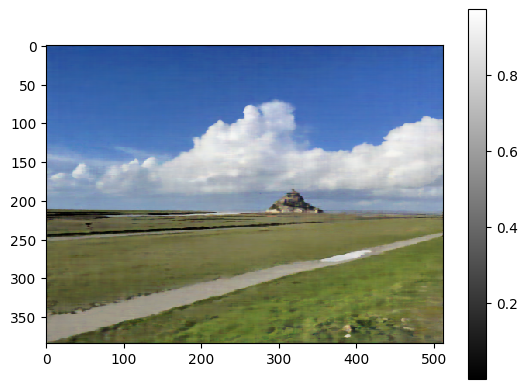

In [21]:
rgb_model = mlp_configurable(input_dim=rgb_input_dim, num_hidden_layers=5, hidden_layer_width=128).to(device)

train(model=rgb_model, input=rgb_coord_queries, expected_output=rgb_img_downsampled.permute(1, 2, 0), num_epochs=1000, loss_print_interval=100, show_interval=1000)

### Wavelength response

The network has only ever seen discrete color inputs at [-1, 0, -1]. What does it do when queried for in-between values? Let's find out, by querying it for some pixel over many samples of the complete range of $c$ from -1 to 1.

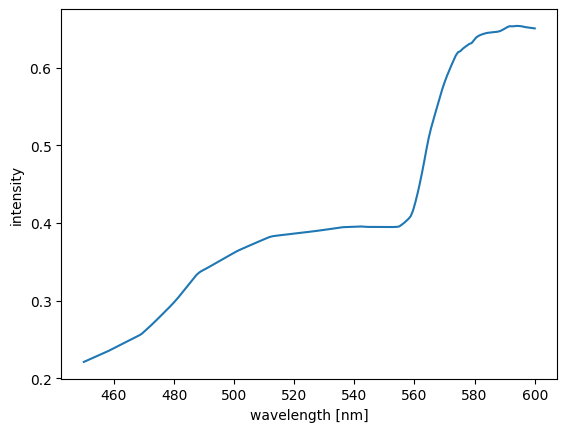

In [22]:
def plot_wavelen_response(model, coord_encoding, x_coord, y_coord,
                          min_wavelen_nm=450,
                          max_wavelen_nm=600):

    # [coord_encoding_len]
    xy_encoded = coord_encoding[y_coord, x_coord]

    samples = torch.arange(-100, 101) / 100
    samples = samples.to(device)

    # repeat the xy encoding into a new sample dimension for the wavelength
    # [coord_encoding_len, num_samples]
    xy_encoded_repeated = xy_encoded.unsqueeze(-1).repeat((1, samples.shape[0]))

    # switch around the dimensions,
    # so that the sampling dimension becomes the batch dimension
    # [num_samples, coord_encoding_len]
    xy_encoded_repeated = xy_encoded_repeated.transpose(0, 1)  # Switch dimensions
    assert xy_encoded_repeated.shape == (len(samples), len(xy_encoded))

    # concat the wavelength sample query to the coordinates
    # [num_samples, coord_encoding_len + 1]
    query = torch.cat([xy_encoded_repeated, samples.unsqueeze(-1)], dim=-1)
    result = model(query)

    intensity_at_samples = result.squeeze().cpu().detach()

    samples_nm = (samples + 1) / 2 * (max_wavelen_nm - min_wavelen_nm) + min_wavelen_nm

    series = pd.Series(
        result.squeeze().cpu().detach(), index=samples_nm.cpu().detach().numpy()
    )
    series.plot(xlabel="wavelength [nm]", ylabel="intensity")
    plt.show()

plot_wavelen_response(rgb_model, coord_encoding=encoded_coords, x_coord=80, y_coord=50)

### Task 4 - Wavelength response interpretation (RGB)

This graph shows the network response for ~200 samples, while it was only trained with values at the extremes and in the center. Is the smoothness of the curve to your expectation?

**Answer:**

### Hyperspectral Imaging

For the final section of this excercise, we want to add more resolution in the color channel of our trained networks. For that, we use the recording from a hyperspectral camera - a camera that records light at many different wavelengths at the same time, not just three.

With hyperspectral cameras, it becomes possible to differentiate materials and surfaces much better than with images taken with a conventional camera. Use cases include medical and agricultural use, and it's an active area of research.

Let's load up a hyperspectral image:

/vol/fob-vol4/mi17/christod/Visual_Computing/.conda/lib/python3.10/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


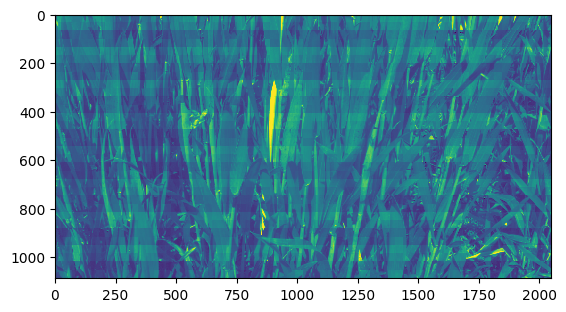

In [24]:
hs_img_file = "/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_07/content/2023-05-17_1_Rcor_enh.png"
bayer_img = iio.imread(hs_img_file)
hs_img = torchvision.transforms.ToTensor()(bayer_img).squeeze(0).to(device)
hs_img_tensor_norm = hs_img / 65535

gamma = 1.8
hs_img_tensor_norm = torchvision.transforms.functional.adjust_gamma(hs_img_tensor_norm, gamma=1/gamma)

imshow(hs_img_tensor_norm)

wavelengths_nm = torch.tensor([460.6594, 466.0551, 476.3369, 484.0140, 494.1334, 506.4071, 513.1407,
        524.3460, 535.8630, 544.3856, 552.9605, 563.5027, 570.5034, 582.2681,
        588.0899, 596.6161]).to(device)


It has only one channel, giving us the direct values from the sensor. Let's look more closely:

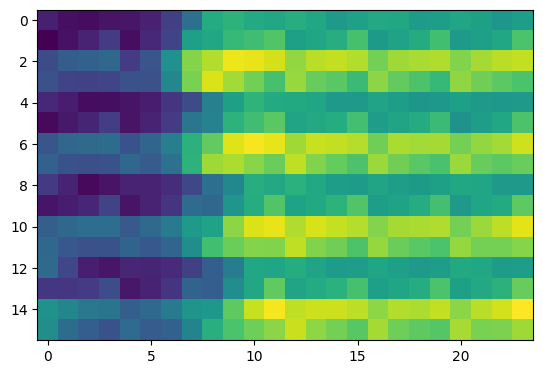

In [25]:
imshow(hs_img_tensor_norm[:16, :24])

We can see a repeating pattern here. That is the 4x4 pattern, of 16 different filters of different wavelenghts, repeating over the image. Let's model the 4x4 pattern, and display it:

Sensor bayer pattern: 
tensor([[460.6594, 466.0551, 476.3369, 484.0140],
        [494.1334, 506.4071, 513.1407, 524.3460],
        [535.8630, 544.3856, 552.9605, 563.5027],
        [570.5034, 582.2681, 588.0899, 596.6161]], device='cuda:2')


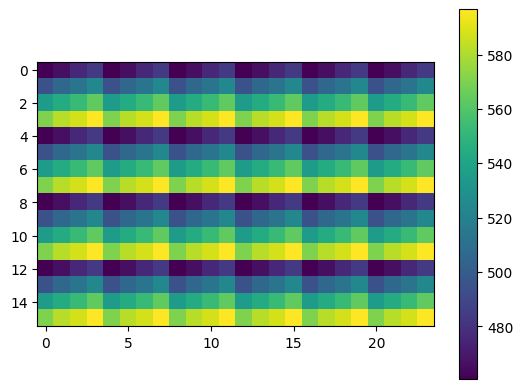

In [26]:
bayer_pattern = torch.arange(16).reshape(4, 4)
print(f"Sensor bayer pattern: \n{wavelengths_nm[bayer_pattern]}")

img_pattern = bayer_pattern.repeat(hs_img.shape[0] // 4, hs_img.shape[1] // 4)

min_wavelen = wavelengths_nm.min()
max_wavelen = wavelengths_nm.max()

px_wavelens = wavelengths_nm[img_pattern]

# [0..1]
px_wavelens_norm = (px_wavelens - min_wavelen) / (max_wavelen - min_wavelen)
# [-1..1]
px_wavelens_norm = 2 * px_wavelens_norm - 1

# [h, w, xy]
coord_grid_hs = create_coord_grid_2d(
    height=hs_img.shape[0], width=hs_img.shape[1]
).to(device)
encoded_coords_hs = positional_encoding(coord_grid_hs[..., 0], coord_grid_hs[..., 1], num_frequencies=8)

# [h, w, coord_encoding + 1]
coords_wavelens = torch.cat([encoded_coords_hs, px_wavelens_norm.unsqueeze(-1)], dim=-1)

imshow(px_wavelens[:16, :24], colorbar=True)

As we already have a color query input, we don't need to change anything with our model. The difference to the RGB image is, that now we have many more samples along the color dimension, but each pixel only has a single sample (vs the RGB image, which has a sample for R, G and B each at every pixel, as it had already been processed from a RAW image).

Image size: 2048 x 1088
Image pixels per trainable parameter: 25.60
Layer (type:depth-idx)                   Param #
mlp_configurable                         --
├─Linear: 1-1                            4,352
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Linear: 2-4                       16,512
│    └─Linear: 2-5                       16,512
├─Linear: 1-3                            129
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 87,041
Trainable params: 87,041
Non-trainable params: 0
Epoch [1/1000], Loss: 0.0256
Epoch [101/1000], Loss: 0.0119
Epoch [201/1000], Loss: 0.0082
Epoch [301/1000], Loss: 0.0065
Epoch [401/1000], Loss: 0.0062
Epoch [501/1000], Loss: 0.0057
Epoch [601/1000], Loss: 0.0058
Epoch [701/1000], Loss: 0.0056
Epoch [801/1000], Loss: 0.0052
Epoch [901/1000], Loss: 0.00

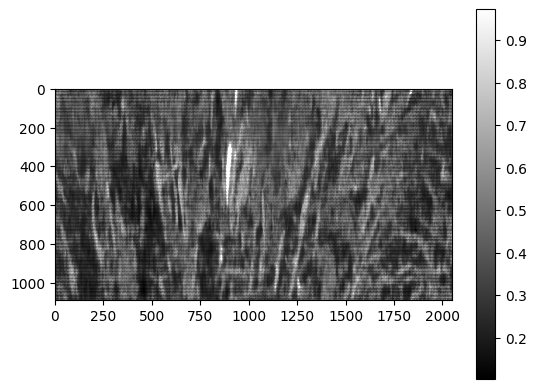

In [27]:
hs_model = mlp_configurable(input_dim=rgb_input_dim, num_hidden_layers=5, hidden_layer_width=128).to(
    device
)
train(model=hs_model, input=coords_wavelens, expected_output=hs_img_tensor_norm, num_epochs=1000, loss_print_interval=100, show_interval=1000)

To render an RGB image, we can create three color channels the size of the image, and request the (-1, 0, 1) values again, to form the image.

Because the camera is not sensitive in all areas of the human vision, and we made some simplifications, the colors may look slightly unnatural. But if all went well, you should see an overall green image with a white stick in the middle, a blue label in the center right, and a yellow brick wall at the top right. Is there enough detail in the image for you to guess what was being recorded?

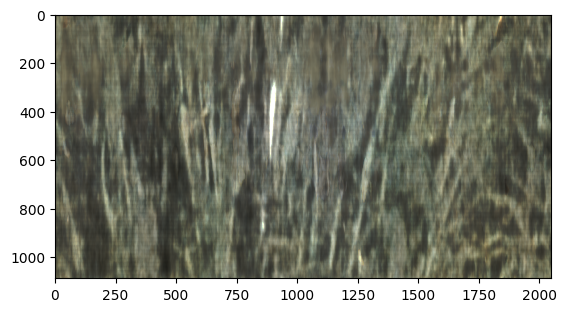

In [28]:
def render_rgb_img(model, input_query):
    with torch.no_grad():
        red_query = input_query.clone()
        red_query[:, :, -1] = 1.0
        red_img = model(red_query).squeeze(-1)
        red_img /= red_img.max()

        green_query = input_query.clone()
        green_query[:, :, -1] = 0
        green_img = model(green_query).squeeze(-1)
        green_img /= green_img.max()

        blue_query = input_query.clone()
        blue_query[:, :, -1] = -1.0
        blue_img = model(blue_query).squeeze(-1)
        blue_img /= blue_img.max()

        rgb_img = torch.stack([red_img, green_img, blue_img], dim=-1)
        imshow(rgb_img.detach())

render_rgb_img(model=hs_model, input_query=coords_wavelens)

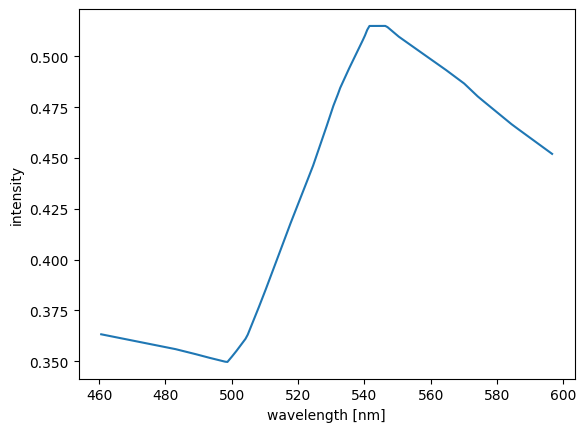

In [29]:
plot_wavelen_response(hs_model, coord_encoding=encoded_coords_hs, x_coord=1500, y_coord=400, min_wavelen_nm=min_wavelen, max_wavelen_nm=max_wavelen)

### Task 5 - Wavelength response interpretation (hyperspectral)

Now we have looked again at the wavelength response of the network, now trained with hyperspectral data. How does it look different from the earlier plot? Is that expected?

**Answer:**